# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


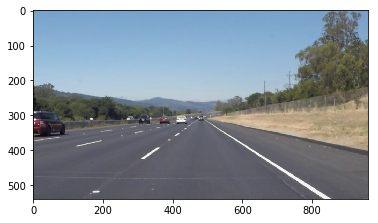

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    
    if len(img.shape) > 2:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    return img
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img,
                            rho,
                            theta,
                            threshold,
                            np.array([]),
                            minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    return lines

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def draw_lines(img,
               left_lane,
               right_lane,
               color_left=[255, 0, 0],
               color_right=[0, 0, 255],
               thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    if len(left_lane) > 0:
        cv2.line(img,
                 (left_lane[0], left_lane[1]),
                 (left_lane[2], left_lane[3]),
                 color_left,
                 thickness)

    if len(right_lane) > 0:    
        cv2.line(img,
                 (right_lane[0], right_lane[1]),
                 (right_lane[2], right_lane[3]),
                 color_right,
                 thickness)

def detect_yellow_and_white(img):
    """Detects the lane colors - yellow and white, in an image frame.
    This will return a binary mask for yellow and white parts of image."""
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # HSV range for yellow
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    mask_yellow = cv2.inRange(img_hsv, yellow_lower, yellow_upper)
    
    # HSV range for white
    white_lower = np.array([0, 0, 235])
    white_upper = np.array([255, 20, 255])
    mask_white = cv2.inRange(img_hsv, white_lower, white_upper)
    
    return cv2.addWeighted(mask_yellow, 1, mask_white, 1, 0)

def draw_left_right_lane(image, lines, ignore_slope = 0.1):
    """Generates the left and right lane lines mask using the lines
    detected by Hough transform. It removes horizontal lines based on slope
    and divides the remaining lines into left and right depending upon slope
    and points location (some outliers/noise will thus be ignored).
    This will return the lane line mask."""
    
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
    
    middle_x = image.shape[1] / 2
    
    if len(lines) == 0:
        return np.zeros_like(image)
    
    # Identify good references for points on left lane and points on
    # right lane
    for line in lines:
        for x1, y1, x2, y2 in line:
            
            slope = 1. * (y2 - y1) / (x2 - x1)
            
            if abs(slope) <= ignore_slope:
                continue
            
            if slope < 0 and x1 <= middle_x and x2 <= middle_x:
                left_line_x.append(x1)
                left_line_y.append(y1)
                left_line_x.append(x2)
                left_line_y.append(y2)
            elif slope >= 0 and x1 > middle_x and x2 > middle_x:
                right_line_x.append(x1)
                right_line_y.append(y1)
                right_line_x.append(x2)
                right_line_y.append(y2)
    
    # Defining min and max y values.
    max_y = image.shape[0]
    min_y = int(image.shape[0] * 0.6)
    
    left_lane = []
    right_lane = []
    
    if len(left_line_x) == len(left_line_y) and \
        len(left_line_x) > 0 and len(left_line_y) > 0:
        left_line = np.polyfit(left_line_x, left_line_y, 1)
        left_min_x = int((min_y - left_line[1]) / left_line[0])
        left_max_x = int((max_y - left_line[1]) / left_line[0])
        
        left_lane.extend([left_min_x, min_y, left_max_x, max_y])
        
    if len(right_line_x) == len(right_line_y) and \
        len(right_line_x) > 0 and len(right_line_y) > 0:
            
        right_line = np.polyfit(right_line_x, right_line_y, 1)
        right_min_x = int((min_y - right_line[1]) / right_line[0])
        right_max_x = int((max_y - right_line[1]) / right_line[0])
        
        right_lane.extend([right_min_x, min_y, right_max_x, max_y])
    
    # Generating lane line mask.
    lane_line_mask = np.zeros_like(image)
    draw_lines(lane_line_mask, 
               left_lane,
               right_lane,
               thickness = 5)
    
    return lane_line_mask

def basic_lane_line_detection(image):
    """Detects basic lane lines in an image frame using Canny edge detection
    and Hough Transform boundary detection.
    This will return the lines detected by Hough Transform."""
    
    imshape = image.shape
    
    gauss_kernel = 5
    canny_low_thres = 100
    canny_high_thres = 200
    hough_rho_res = 1
    hough_theta_res = 1. * math.pi / 180
    hough_thres = 10
    hough_min_line_len = 20
    hough_max_line_gap = 10
    
    gray = grayscale(image)
    blur = gaussian_blur(gray, gauss_kernel)
    edges = canny(blur, canny_low_thres, canny_high_thres)
    
    return hough_lines(edges, 
                        hough_rho_res, 
                        hough_theta_res, 
                        hough_thres, 
                        hough_min_line_len, 
                        hough_max_line_gap)  

## Test Images

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg']

## Build a Lane Finding Pipeline



In [5]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image, plot = False):
    
    imshape = image.shape
    
    # Masking everything except yellow and white colors.
    lane_color_mask = detect_yellow_and_white(image)
    
    # Removing all instances of yellow and white based on ROI.
    vertices = np.array([[[60, imshape[0]],
                         [imshape[1] / 2 - 25, imshape[0] / 2 + 60],
                         [imshape[1] / 2  + 25, imshape[0] / 2 + 60],
                         [imshape[1] - 60, imshape[0]]]],
                        dtype=np.int32)
    masked = region_of_interest(lane_color_mask, vertices)  
 
    # Finding basic lane lines.
    lines = basic_lane_line_detection(masked)
    
    # Generating a mask with the left lane in red and right lane
    # in blue.
    lane_line_mask = draw_left_right_lane(image, lines)

    # Adding the mask to the image.
    result = weighted_img(lane_line_mask, image, 0.7, 1)
    
    if plot:
        fig = plt.figure()
        ax0 = fig.add_subplot(3, 1, 1)
        ax1 = fig.add_subplot(3, 1, 2)
        ax2 = fig.add_subplot(3, 1, 3)
        ax0.set_title('ROI + Yellow/White mask')
        ax0.imshow(masked)
        ax1.set_title('Lane Line Mask')
        ax1.imshow(lane_line_mask)
        ax2.set_title('Result')
        ax2.imshow(result)
        plt.rcParams["figure.figsize"] = (30,20)
        plt.show()
    
    return result

## Testing on SolidWhiteRight

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
# To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# To do so add .subclip(start_second,end_second) to the end of the line below
# Where start_second and end_second are integer values representing the start and end of the subclip
# You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

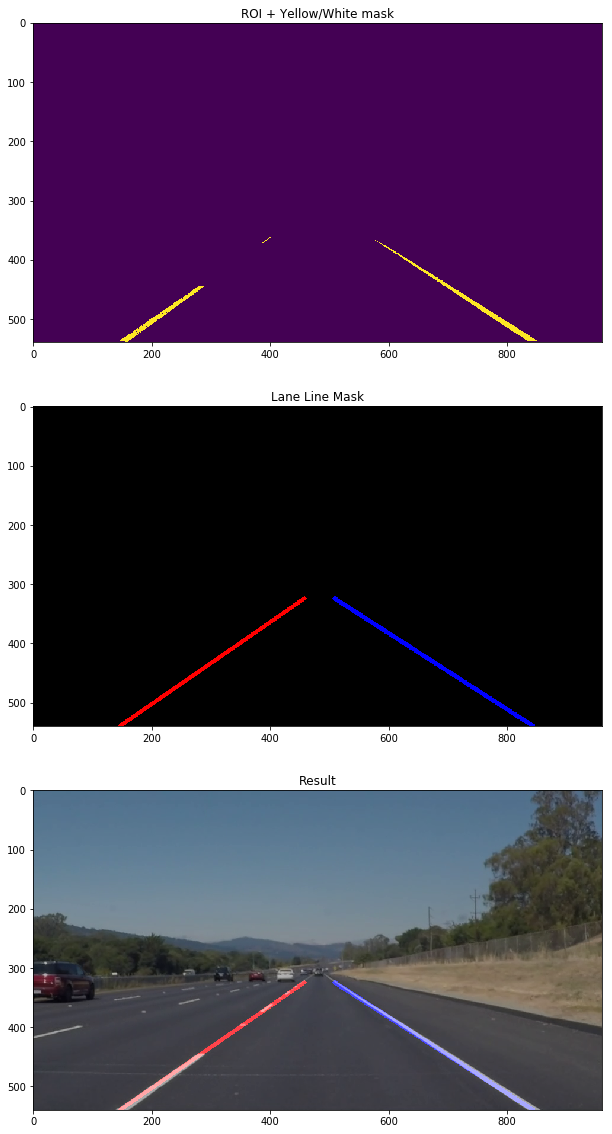

In [11]:
# Plotting masks generated as part of processing
frame = clip1.get_frame(1)
_ = process_image(frame, True)

In [9]:
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 16.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.75 s, sys: 264 ms, total: 4.01 s
Wall time: 15 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Testing on SolidYellowLeft

In [15]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

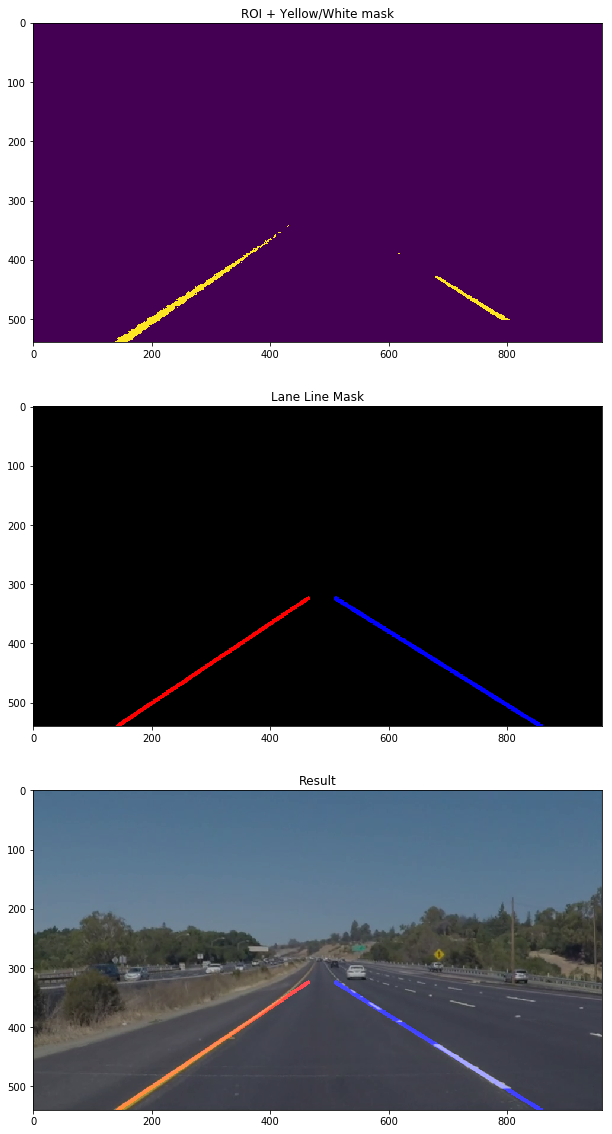

In [16]:
# Plotting masks generated as part of processing
frame = clip2.get_frame(1)
_ = process_image(frame, True)

In [17]:
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:45<00:00, 14.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 11.9 s, sys: 686 ms, total: 12.6 s
Wall time: 47.3 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [19]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')

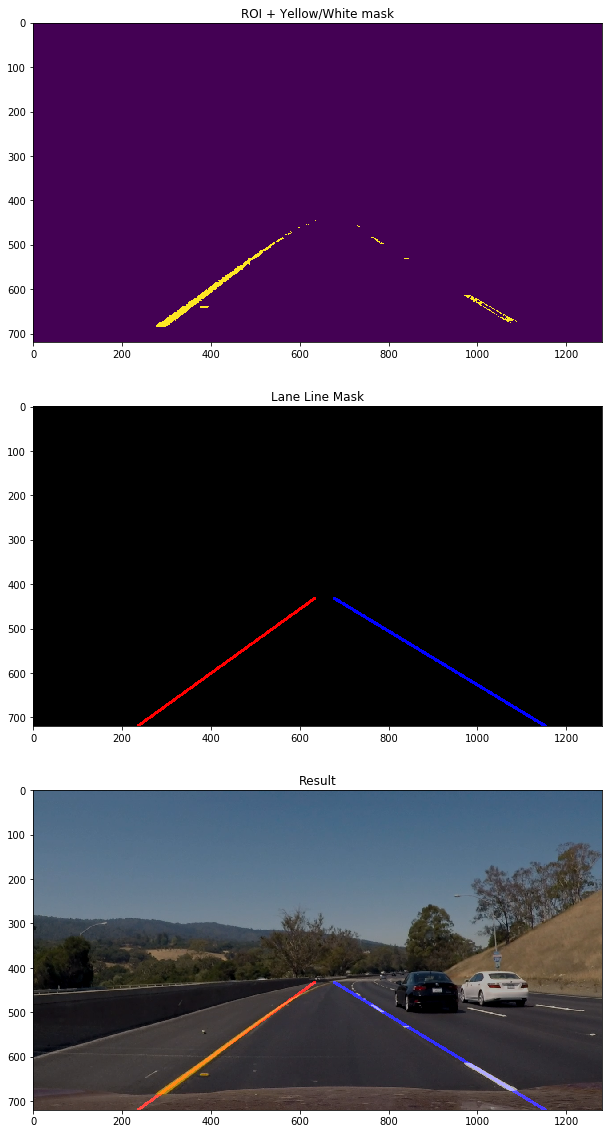

In [20]:
# Plotting masks generated as part of processing
frame = clip3.get_frame(1)
_ = process_image(frame, True)

In [21]:
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:32<00:00,  7.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.32 s, sys: 496 ms, total: 7.81 s
Wall time: 35.3 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))